# Chuẩn bị dữ liệu

In [ ]:
import codecs
def _generate_examples(filepath):
    examples = []
    with codecs.open(filepath, "rb") as f:
        for id_, row in enumerate(f):
            # One non-ASCII byte: sisterBADBYTEcity. We replace it with a space
            label, _, text = row.replace(b"\xf0",
                                         b" ").strip().decode().partition(" ")
            coarse_label, _, fine_label = label.partition(":")
            examples.append((id_, {
                "label-coarse": coarse_label,
                "label-fine": fine_label,
                "text": text,
            }))
    return examples

In [ ]:
train = _generate_examples("train_5500.label")
test = _generate_examples("TREC_10.label")

In [ ]:
# lấy danh sách các nhãn trong dữ liệu huấn luyện
labels = [x['label-coarse'] for _, x in train]
set_labels = list(set(labels))
label2id = {x: i for i, x in enumerate(set_labels)}
id2label = {i: x for i, x in enumerate(set_labels)}

print("------")
print(len(labels))
print("------")
print(set_labels)
print("------")
print(label2id)
print("------")
print(id2label)

------
5452
------
['ABBR', 'HUM', 'NUM', 'ENTY', 'DESC', 'LOC']
------
{'ABBR': 0, 'HUM': 1, 'NUM': 2, 'ENTY': 3, 'DESC': 4, 'LOC': 5}
------
{0: 'ABBR', 1: 'HUM', 2: 'NUM', 3: 'ENTY', 4: 'DESC', 5: 'LOC'}


In [ ]:
train_target = [label2id[x['label-coarse']] for _, x in train]
train_data = [x['text'] for _, x in train]

test_data = [x['text'] for _, x in test]
test_target = [label2id[x['label-coarse']] for _, x in test]


print("#training size", len(train))
print("#testing size", len(test))
print(train[0])
print(train[1])
print(test[0])
print(test[1])
print(train_data[0], train_target[0])
print(train_data[1], train_target[1])

#training size 5452
#testing size 500
(0, {'label-coarse': 'DESC', 'label-fine': 'manner', 'text': 'How did serfdom develop in and then leave Russia ?'})
(1, {'label-coarse': 'ENTY', 'label-fine': 'cremat', 'text': 'What films featured the character Popeye Doyle ?'})
(0, {'label-coarse': 'NUM', 'label-fine': 'dist', 'text': 'How far is it from Denver to Aspen ?'})
(1, {'label-coarse': 'LOC', 'label-fine': 'city', 'text': 'What county is Modesto , California in ?'})
How did serfdom develop in and then leave Russia ? 4
What films featured the character Popeye Doyle ? 3


# Pipeline

In [ ]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

C =  3.0
use_idf = True
ngram_range=(1, 2)

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=ngram_range)),
    ('tfidf', TfidfTransformer(use_idf=use_idf)),
    ('clf', svm.LinearSVC(C=C)),
])

In [ ]:
text_clf.fit(train_data, train_target)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=3.0))])

In [ ]:
text_clf.get_params()

{'memory': None,
 'steps': [('vect', CountVectorizer(ngram_range=(1, 2))),
  ('tfidf', TfidfTransformer()),
  ('clf', LinearSVC(C=3.0))],
 'verbose': False,
 'vect': CountVectorizer(ngram_range=(1, 2)),
 'tfidf': TfidfTransformer(),
 'clf': LinearSVC(C=3.0),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 2),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'clf__C': 3.0,
 'clf__class_weight': None,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__loss': 'squared_hinge',
 '

# Predict

In [ ]:
docs_new = ['what is computer',
            'who is Newton',
            'when is the Tet holiday ?']

predicted = text_clf.predict(docs_new)
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, id2label[category]))

'what is computer' => DESC
'who is Newton' => HUM
'when is the Tet holiday ?' => NUM


In [ ]:
predicted = text_clf.predict(test_data)
ncorrect = sum([y_pred == y for y_pred, y in zip (predicted, test_target)])
accurracy = ncorrect / len(test_target)
accurracy

0.892

In [ ]:
# y_pred = text_clf['clf'].predict(text_clf['tfidf'].transform(text_clf['vect'].transform(test_data)))
# ncorrect = sum([y_pred == y for y_pred, y in zip (predicted, test_target)])
# accurracy = ncorrect / len(test_target)
# accurracy

# GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': (1.0, 2.0, 3.0)
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(train_data, train_target)

In [ ]:
gs_clf.best_score_

0.8637176565561434

In [ ]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__C: 3.0
tfidf__use_idf: True
vect__ngram_range: (1, 2)


In [ ]:
gs_clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=3.0))])

Optimal number of features : 97


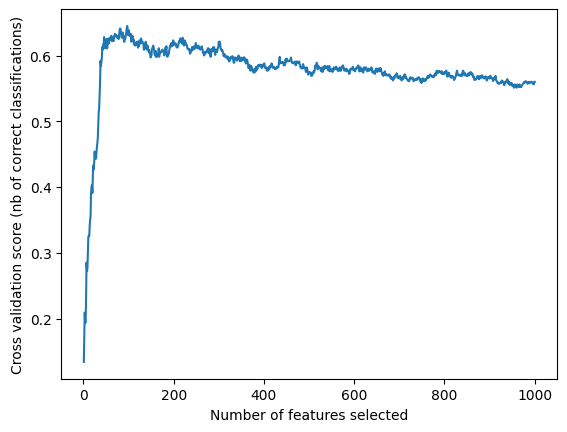

In [ ]:

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=1000, n_informative=20,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
         rfecv.cv_results_['mean_test_score'])
plt.show()

In [ ]:
rfecv.cv_results_

{'mean_test_score': array([0.16 , 0.223, 0.251, 0.292, 0.343, 0.369, 0.398, 0.457, 0.492,
        0.499, 0.51 , 0.54 , 0.594, 0.598, 0.623, 0.625, 0.613, 0.647,
        0.659, 0.653, 0.654, 0.684, 0.688, 0.684, 0.684]),
 'std_test_score': array([0.004, 0.005, 0.005, 0.002, 0.015, 0.017, 0.004, 0.003, 0.02 ,
        0.001, 0.006, 0.008, 0.002, 0.002, 0.011, 0.009, 0.017, 0.011,
        0.027, 0.029, 0.03 , 0.026, 0.028, 0.026, 0.02 ]),
 'split0_test_score': array([0.164, 0.228, 0.246, 0.29 , 0.328, 0.352, 0.394, 0.454, 0.472,
        0.5  , 0.516, 0.548, 0.592, 0.596, 0.634, 0.634, 0.63 , 0.658,
        0.686, 0.682, 0.684, 0.71 , 0.716, 0.71 , 0.704]),
 'split1_test_score': array([0.156, 0.218, 0.256, 0.294, 0.358, 0.386, 0.402, 0.46 , 0.512,
        0.498, 0.504, 0.532, 0.596, 0.6  , 0.612, 0.616, 0.596, 0.636,
        0.632, 0.624, 0.624, 0.658, 0.66 , 0.658, 0.664])}